# <u>Development of a TSS algorithm for Lake Tempe</u>

**Contents**

- [Background](#Background)
  - [Overview](#Overview)
  - [Suspended sediments](#Suspended-sediments)
  - [TSS dataset](#TSS-dataset)
- [Notebook setup](#Notebook-setup)
- [Lake boundary](#Lake-boundary)
- [Ground-based TSS dataset](#Ground-based-TSS-dataset)
  - [Loading up the spreadsheet data](#Loading-up-the-spreadsheet-data)
  - [Data clean-up](#Data-clean-up)
  - [Extracting the site numbers](#Extracting-the-site-numbers)
  - [Loading up the shapefile data](#Loading-up-the-shapefile-data)
  - [Consistency checks](#Consistency-checks)
  - [Splitting the Sentinel-2 and Landsat-8 datasets](#Splitting-the-Sentinel-2-and-Landsat-8-datasets)
  - [Visualising the data](#Visualising-the-data)
- [Remote sensing data](#Remote-sensing-data)
  - [Spatial and temporal extents](#Spatial-and-temporal-extents)
  - [DataCube query](#DataCube-query)
  - [Data load](#Data-load)
  - [Data clean-up](#Data-clean-up)
  - [Filtering out land pixels](#Filtering-out-land-pixels)
  - [Visualising the datasets](#Visualising-the-datasets)
  - [Extracting the S2 data at the sampling locations](#Extracting-the-S2-data-at-the-sampling-locations)
- [TSS algorithm for Lake Tempe](#TSS-algorithm-for-Lake-Tempe)
  - [Fitting the algorithm](#Fitting-the-algorithm)
  - [Visualising the fitted relationship](#Visualising-the-fitted-relationship)
  - [Predicting TSS from Sentinel-2 data](#Predicting-TSS-from-Sentinel-2-data)

# Background

## Overview

This notebook illustrates how to develop an algorithm for the calculation of total suspended sediments (TSS) from remote sensing data for Lake Tempe, South Sulawesi. In this notebook, we focus on the use of Sentinel-2 optical satellite imagery for this purpose &ndash; the exact same approach can be applied to other satellite sensors, such as Landsat-8. The TSS algorithm is fitted on the basis of ground-based samples acquired over Lake Tempe.

## Suspended sediments

In order to derive estimates of TSS concentration (in mg/L) from the remote sensing data, we need a specific formula (algorithm) that characterises the relationship between the Sentinel-2 spectral band values and the true TSS measurements. Such a formula needs to be calibrated on the basis of TSS measurements sampled during one or more field campaigns on the lake of interest. Once calibrated (fitted), this algorithm can be applied to new Sentinel-2 images for any (water) pixel in order to calculate estimates of TSS.

In this notebook, we rely on pre-existing research published in the following manuscript:

 > E. Pandhadha <i>et al.</i>, 2020. Total Suspended Solid (TSS) Estimation in Lake Tempe, South Sulawesi Using Sentinel-2B Imagery. Journal of Engineering Technology and Applied Physics, Special Issue on Remote Sensing for Sustainable Environment, no. 1 (2020). [DOI:10.33093/jetap.2020.x1.4](http://dx.doi.org/10.33093/jetap.2020.x1.4)

In this paper, the remote-sensing-based formula (model) used to derive values for the $\text{TSS}$ parameter of interest is as follows: 

$$
\text{TSS} = \alpha \cdot \text{NSMI} + \beta \\
\text{NSMI} = \frac{ \text{red}+\text{green}-\text{blue} }{ \text{red}+\text{green}+\text{blue} }
$$

where $\text{red}$, $\text{green}$ and $\text{blue}$ correspond to the respective Sentinel-2 bands, and $\text{NSMI}$ represents the Normalised Suspended Material Index. In the above paper, the model fitting process resulted in specific coefficient values, namely $\alpha = 775.98$ and $\beta = -93.606$. In this notebook, we will demonstrate how this TSS model can be (re)fitted on the basis of a (new) dataset of TSS measurements, in order to achieve a TSS algorithm taylored to a specific set of sampling conditions.

Note that in the above paper, the authors implement a pre-processing step aiming to remove pixels affected by sun-glint in the Sentinel-2 data. This step is _not_ implemented in this notebook.

And finally, note also that there exist many different TSS formulae that could form the basis for this work. A large variety of algorithm types could be used and developped in this notebook, using different combinations of spectral bands, data from different satellites, and/or different mathematical formulae. For instance, a TSS algorithm for MODIS could look like this:

$$
\text{TSS} = \alpha \cdot \left( \frac{\text{Rrs_531}}{\text{Rrs_667}} \right)^\beta
$$

Further models of interest can be found in the existing literature on the topic of TSS monitoring using remote sensing data. An important aspect of the scientist's research and development work in relation to this is to fit and test a wide variety of potential models of interest, and then make a decision as to which one provides the best results (goodness of fit) with the datasets at hand. In this respect, this example notebook provides a methodology that can be used to develop and fit _one_ of those models.

## TSS dataset

In this notebook, we will make use of a dataset of TSS measurements acquired on Lake Tempe in November 2021. This dataset was provided in a document named `TOTAL SUSPENT SEDIMEN.xlsx`, which has been copied to the local folder `ancillary_data` in this repository. The following image provides a snapshot of this spreadsheet.

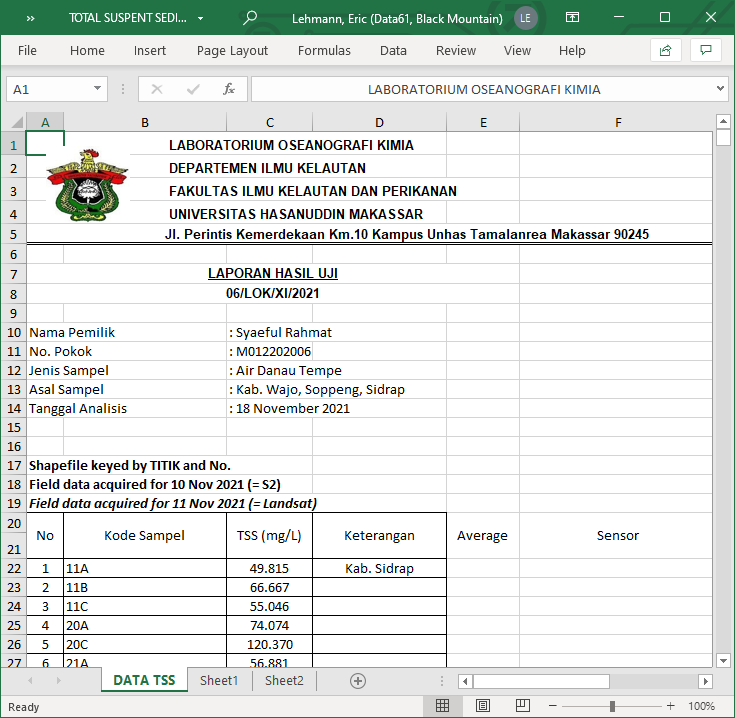

Among others, this `.xlsx` spreadsheet document contains the individual TSS measurements acquired at various sampling locations labelled as per the `Kode Sampel` column. In the following, we will go through various steps illustrating how to load, clean up and pre-process this dataset, ready for use in the development of the TSS algorithm.

In conjunction with this ground-based TSS dataset, the shapefile `Water_Sample_Coordinates` provides (among others) the latitude / longitude coordinates for each of the sampling points. The data in this shapefile can be accessed from the EASI SE Asia geo-server (https://geoserver.sg-dev.easi-eo.solutions/geoserver/web/), and this notebook will also demonstrate how to fetch and process this dataset.

The following list provides a few observations related to this dataset of ground-based TSS data:
 - multiple measurements (between two and four) were recorded at each of the sampling locations &ndash; these replicated measurements can be used for the calculation of uncertainty metrics such as standard deviation, precision, etc., and for the removal (to some extent) of variability due to human error, varying local conditions, etc.
 - the TSS values were acquired on two separate days, namely:
   - Nov. 10, 2021, to coincide with an overpass of the Sentinel-2 satellite sensor
   - Nov. 11, 2021, to coincide with an overpass of the Landsat-8 satellite sensor
 - the satellite sensor (and therefore, the acquisition date) for which the TSS data was acquired is provided in the `Water_Sample_Coordinates` shapefile (`Ket_Citra` feature property).

# Notebook setup

First, let's import the key Python packages and supporting functions required in this notebook. Note here that we will not make use of the `Dask` Python library &ndash; the remote sensing dataset we will be dealing with (singe time slice over a relatively small region of interest) is small enough that we will not need the distributed processing and storage capabilities offered by `Dask` here.

In [ ]:
### System, I/O, etc.
import sys
from requests import Request
from IPython.core.display import HTML

### Datacube 
import datacube
from datacube.utils import masking
from odc.algo import enum_to_bool

### Data tools
import numpy as np
import re
import xarray as xr
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm

### Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### EASI tools
sys.path.append('/home/jovyan/git_hub_notebook/scripts/')
   # 'scripts' available by cloning this repository: https://dev.azure.com/csiro-easi/easi-hub-public/_git/hub-notebooks
from app_utils import display_map

In [ ]:
### Miscellaneous:
cmap1 = LinearSegmentedColormap.from_list("cmap1", ["gainsboro", "gainsboro"])   # cmap for greyed out land pixels
dc = datacube.Datacube(app="Lake_Tempe_TSS_algorithm")   # connect to the EASI database

# Lake boundary

To provide ancillary information in the plots further below, we will use a vector of the Lake Tempe boundary over the region of interest. This polygon data can be loaded from an existing shape file provided in the `ancillary_data` folder in this repository.

In [ ]:
shape_file = './ancillary_data/Base Map/Boundary_administration.shp'

### Load the shapefile
shp = gpd.read_file(shape_file)

display( HTML(f"<h4>Shape file data:</h4>") )
display(shp[:10])

display( HTML(f"<h4>Coordinate reference system (CRS):</h4>") )
shp.crs

We can see here that the vector data within the shapefile is in the projection `EPSG:4326` (latitude/longitude), which is the same as the projection used in the dataset of TSS data &ndash; we thus do not need to re-project the shapefile data to a different CRS here. 

We now filter the shapefile contents to only select those polygons associated with Lake Tempe.

In [ ]:
### Remove unwanted polygons
print("Selected polygons are:")
drop_list = []
for ff in shp.iterrows():
    tmp = ff[1].Village.lower()
    if 'tempe' in tmp and 'danau' in tmp: print('  -', ff[0],ff[1].Village)
    else: drop_list.append( ff[0] )
        
shp.drop( drop_list, inplace=True )   # remove polygons

### Plot
shp.boundary.plot(figsize=(8,8))
plt.xlabel("longitude"); plt.ylabel("latitude")
plt.title("Lake Tempe boundary");

# Ground-based TSS dataset

## Loading up the spreadsheet data

To read data directly from the `.xlsx` document, we use the Pandas `read_excel` functionality, which requires the Python library `openpyxl`. This module is unfortunately not installed by default on the current EASI platform, and thus requires manual installation (preferrably in a separate virtual environment). 

As an alternative to a manual install, a pre-processed version of the TSS dataset, saved as a plain `.csv` file, is also provided in the `ancillary_data` folder &ndash; this `.csv` file can be used here instead of the original `.xlsx` document, thus avoiding the use of `openpyxl`.

In [ ]:
try:
    import openpyxl   # needs manual install -- fails if not available
    print('Processing original .xlsx data (using \'openpyxl\')...')
    process_xlsx_dataset = True   # indicates whether to use the .xlsx document
except:   # if 'openpyxl' not available, use pre-processed .csv file
    process_xlsx_dataset = False
    print('Loading pre-processed TSS data from .csv file...')
    TSS_df = pd.read_csv('./ancillary_data/TOTAL SUSPENT SEDIMEN_proc.csv')

In the following cell, we first set some parameters determining how the TSS data values are organised inside the `.xlsx` document, and subsequently load up the data using `pd.read_excel`.

In [ ]:
if process_xlsx_dataset:
    file_name = './ancillary_data/TOTAL SUSPENT SEDIMEN.xlsx'
    sheet_name = 'DATA TSS'   # sheet of interest within .xlsx file
    header_start_line = 19   # details of the structure of the data inside the .xlsx file
    n_rows_to_read = 63
    rows_to_skip = [20,51,52]
    cols_to_read = [0,1,2]
    
    ### Read TSS data from .xlsx file
    TSS_df = pd.read_excel( file_name, sheet_name=sheet_name, 
                            usecols=cols_to_read, header=header_start_line, 
                            nrows=n_rows_to_read, skiprows=rows_to_skip )
    
    ### Show the TSS dataset (split horizontal format, for convenience)
    nrow_disp = 5
    tmp = np.ceil( TSS_df.shape[0]/nrow_disp )
    for rr in range(nrow_disp):
        i1, i2 = int(rr*tmp), int((rr+1)*tmp)
        display( TSS_df[i1:i2].T )

A quick look at these data values indicates that the TSS dataset has been properly loaded, and is now available within the notebook as a `Pandas` dataframe.

## Data clean-up

Before making use of this dataset, it is good practice to investigate its characteristics in more detail, so as to identify potential issues that might bias the results further below. Inspecting this specific dataset, we can here gather the following:
 - the `Kode Sampel` column contains the labels of the sample points (a.k.a. "Titik")
 - the `TSS` column evidently contains the corresponding values of TSS recorded at each sampling point
 - there appears to be between two and four consecutive (repeated) measurements recorded for each of the sample points
 - the entries are all entered _sequentially_ in the spreadsheet, and grouped together for each sampling point; in other words, all measurements taken for a given sample point appear _one after the other_ in the above dataframe.
 
The only exception to this last observation is the final entry in the dataframe: while the previous two `Kode Sampel` items read "Watalipu 16", the last entry is labelled "Watalipu 18" &ndash; this could be mis-interpreted as being a measurement for `Kode Sampel` nr. 18, i.e. potentially belonging to the series of "Leppangeng 18" measurements. The "Leppangeng 18" measurements, however, can be seen to exhibit TSS values around 40 mg/L, whereas the TSS value for "Watalipu 18" is 74.5 mg/L, which is substantially above 40 mg/L and more in tune with the measurements recorded at the "Watalipu 16" site (all above 54.5 mg/L).

As a result, we will here assume that the last recording ("Watalipu 18") has been mis-labelled, and should read "Watalipu 16 Bawah" instead of "Watalipu 18 Bawah".

In [ ]:
### Correct labelling of last entry
if process_xlsx_dataset:
    TSS_df.at[TSS_df.index[-1],'Kode Sampel'] = 'Watalipu 16 Bawah'
    display( TSS_df.tail() )   # last few entries in the data frame

In [ ]:
### Save the pre-processed dataset to .csv
if process_xlsx_dataset:
    TSS_df.to_csv('./ancillary_data/TOTAL SUSPENT SEDIMEN_proc.csv', index=False)

## Extracting the site numbers

As can be seen from the dataset, the labelling used for the `Kode Sampel` entries identify repeated measurements for all sampling sites, which themselves are labelled with integer numbers. In the following code cell, we now extract the (integer) site number for each entry in the dataset.

In [ ]:
TSS_df['site_nr'] = [ int(re.findall(r'\d+', item)[0]) for item in list(TSS_df['Kode Sampel']) ]
TSS_df

Having multiple measurements at each sampling site is valuable, e.g. in order to quantify the variability (error characteristics) in the TSS measurements due to factors such as human error, varying environmental conditions, etc. To start with, however, we will here simply "collapse" these multiple measurements by taking the mean of the TSS values at each sampling site.

In the next couple of code cells, we achieve this by first creating groups among the rows of the dataframe &ndash; all rows with identical sampling site number (`site_nr`) will be grouped together, and will then be used to calculate the (group-based) average TSS value at that sampling site. In doing so, however, `Pandas` will also attempt to calculate the mean values of the other columns in the dataset, including the `No` and `Kode Sampel` columns &ndash; these results obviously do not make sense here, and thus we remove these columns prior to the grouping and averaging operations.

In [ ]:
tmp = TSS_df.drop(['No','Kode Sampel'], axis=1)
tmp

In [ ]:
### Group the data, then calculate the average
mean_TSS_df = tmp.groupby('site_nr').mean()
mean_TSS_df.T

These are the averaged TSS values for each of the sampled sites on Lake Tempe. From this result, we can also observe that a total of 25 locations have apparently been sampled originally (`site_nr` ranging up to 25), with data missing for sites 1, 6, 12 and 19 &ndash; overall, only 21 sampling locations are available in the dataset.

## Loading up the shapefile data

The `.xlsx` document processed so far has been provided in conjunction with a corresponding shapefile providing further information about the data; this includes namely the longitude / latitude coordinates of the sampling points, together with the satellite sensor for which the data was recorded (which in turn identifies the dates of acquisition).

The shapefile data can be accessed from the EASI SE Asia geo-server [here](https://geoserver.sg-dev.easi-eo.solutions/geoserver/web/). To load up the data in this notebook, we follow the steps provided in another EASI notebook provided by Ronnie Taib [here](https://github.com/unhas-eo/datacube-notebooks/blob/main/Ronnie/geoserver_access.ipynb).

In [ ]:
### Geo-server details
WFS_URL = "https://geoserver.sg-dev.easi-eo.solutions/geoserver/unhas/ows?service=WFS"
WFS_LAYER = "unhas:Water_Sample_Coordinates"

In [ ]:
### Parameters for fetching the data
params = dict( service = 'WFS', 
               version = "1.1.1", 
               request = 'GetFeature',
               typeName = WFS_LAYER,
               outputFormat = 'json' )

### Parse the URL with parameters
req = Request('GET', WFS_URL, params=params).prepare().url

### Read data from URL
wfs_data = gpd.read_file(req)

print(f"'{WFS_LAYER}' data is of shape {wfs_data.shape}")
display(wfs_data)

The columns of interest here are as follows:
 - `TITIK`: index of the sampling locations for each TSS value &ndash; these correspond to the `site_nr` in the above data frame `TSS_df` of TSS measurements (from the `.xlsx` spreadsheet)
 - `X`, `Y` and `geometry`: these columns contain the latitude / longitude coordinates of the sampling locations
 - `Ket_Citra`: satellite sensor for which the TSS measurements were recorded, i.e. for the Sentinel-2 or Landsat-8 overpass, corresponding to the acquisition dates 2021-11-10 and 2021-11-11, respectively
 - `TSS_mg_L`: TSS values at the sampling locations &ndash; these appear to be the averaged values of the repeated measurements recorded in the `.xlsx` spreadsheet.
 
Another observation here is that several of the TSS values are set to 0.0000, which would indicate that the TSS measurement process has failed for these specific sampling points. In the following, we will thus remove these data points from the shapefile dataset.

In [ ]:
### Pre-process shapefile dataset
wfs_data = wfs_data.drop(['id','Lbr_Sungai','DESA','KECAMATAN','KABUPATEN','PROVINSI','TIM_SURV'], axis=1)   # remove unwanted columns
wfs_data.TITIK = wfs_data.TITIK.astype(int)   # replace 'TITIK' strings with integers

### Remove rows with 0.0 TSS values
tmp = np.where( wfs_data['TSS__mg_L_']==0.0 )[0]
wfs_data.drop(tmp, axis=0, inplace=True)

### Sort the data by 'TITIK' values
wfs_data.sort_values('TITIK', inplace=True, ignore_index=True)

wfs_data

## Consistency checks

A good way to double-check the TSS dataset that will be used in the rest of this notebook is to check the consistency between the averaged TSS data (derived from the "corrected" spreadsheet data) and the above "cleaned-up" TSS values extracted from the shapefile. 

First, we can check that both datasets have the same number of data points:

In [ ]:
mean_TSS_df.shape[0] == wfs_data.shape[0]

We here also ensure that the data points are ordered in the same way in both datasets:

In [ ]:
list(mean_TSS_df.index) == list(wfs_data.TITIK)

And finally, we can double-check that the TSS values are the same. The comparison of floating-point numbers is, however, somewhat tricky as a result of round-off (computational) differences having been introduced at various stages of the processing (e.g. when calculating averages) and data storage (e.g. when saving to a `.csv` or `.shp` file). Thus, we can double-check that any difference between the datasets is very small:

In [ ]:
TSS_mean_arr = np.array(mean_TSS_df['TSS (mg/L)'])
TSS_wfs_arr = np.array(wfs_data['TSS__mg_L_'])

TSS_mean_arr - TSS_wfs_arr

The Numpy function `isclose()` can also be used to assert the approximate equality of the two datasets of floating-point values:

In [ ]:
np.isclose( TSS_mean_arr, TSS_wfs_arr ).all()

We can now be confident that both datasets are consistent (and are thus somewhat "validated"). In the following, we will only make use of the `wfs_data` dataset, which contains all the information required in the rest of this notebook, namely the sampling location, (average) TSS value, and satellite sensor with associated acquisition date for each measurement.

## Splitting the Sentinel-2 and Landsat-8 datasets

The TSS dataset currently contains measurements acquired on two separate days (for Sentinel-2 and Landsat-8, respectively). These two subsets of the data basically need to be processed individually, and we can thus split the TSS dataset into two separate Sentinel-2 (S2) and Landsat-8 (LS8) dataframes.

In [ ]:
### Row indices for each satellite
S2_ind = np.where( ['sentinel' in item.lower() for item in wfs_data.Ket_Citra] )[0]
LS8_ind = np.where( ['landsat' in item.lower() for item in wfs_data.Ket_Citra] )[0]

### Split the data frame
S2_wfs_data = wfs_data.drop(LS8_ind)
LS8_wfs_data = wfs_data.drop(S2_ind)

display( HTML(f"<h4>Sentinel-2 dataset:</h4>") )
display(S2_wfs_data)

display( HTML(f"<h4>Landsat-8 dataset:</h4>") )
display(LS8_wfs_data)

For demonstration purposes, in the rest of this notebook we will focus only on the data acquired for the Sentinel-2 overpass on Nov. 10, 2021. This notebook can of course be updated, in a straightforward manner, to make use of the Landsat-8 dataset from here onwards, thereby resulting in a fitted TSS algorithm specific to Landsat-8 (instead of Sentinel-2).

## Visualising the data

We can now provide a plot of the sampling locations for the Sentinel-2 data, as follows.

In [ ]:
S2_wfs_data.plot(figsize=(10,10))
shp.boundary.plot(ax=plt.gca());

This plot provides an overview of the sampling locations in and around Lake Tempe, as well as Lake Sidenreng to the north-west of Lake Tempe (and for which no polygon was extracted from the boundary administration shapefile).

# Remote sensing data

We now turn to the remote sensing data (Sentinel-2), which we can extract for the date and region of interest by means of the EASI DataCube API. 

In the following, the satellite data will be used to:
 1. provide a display of the satellite image to cross-check the sampling locations with actual land cover on the date of acquisition, and
 1. extract the remote sensing (spectral) data at the sampling locations, as needed for the calibration of the TSS algorithm (model fitting).

## Spatial and temporal extents

The region of interest for the remote sensing data is derived from the extents of the above TSS dataset. The utility function `display_map` here provides a convenient overview of the selected latitude / longitude extents (with generic background map data).

In [ ]:
buffer_deg = 0.05   # some buffer around the TSS dataset extents

### Region of interest
min_longitude, max_longitude = wfs_data.X.min()-buffer_deg, wfs_data.X.max()+buffer_deg
min_latitude, max_latitude = wfs_data.Y.min()-buffer_deg, wfs_data.Y.max()+buffer_deg

display_map( x = (min_longitude,max_longitude), 
             y = (min_latitude,max_latitude) )

A quick look at the Sentinel-2 dataset available on the current EASI deployment (using the [EASI ODC Explorer](https://explorer.sg-dev.easi-eo.solutions/products/s2_l2a/extents)) indicates that data is indeed available during November 2021, which should thus include the selected Sentinel-2 date of interest.

In [ ]:
### Date of S2 overpass
S2_date = '2021-11-10'

## DataCube query

Also from the ODC Explorer, we can gather that the Sentinel-2 product to use in this notebook is labelled `s2_l2a`.

In [ ]:
product = 's2_l2a'     # Sentinel-2 product

The list of satellite bands (and derived layers) for this product can be provided as follows:

In [ ]:
dc.list_measurements().loc[product]

According to the TSS formula provided at the beginning of this notebook, we here select only those spectral bands relevant to our analysis (i.e. `red`, `green` and `blue`). In addition, we also load the `SCL` layer (or its known alias `qa`) of pixel QA data (quality assessment), which will allow us to clean up the dataset. In addition, the `swir_2` band will also be used further below to create a mask of non-water pixels.

We can now initialise the main parameters of a datacube query, which we subsequently use to load the relevant Sentinel-2 data using `dc.load()`. Here, we select `epsg:4326` as coordinate reference system for the satellite data, so as to remain consistent with the existing dataset of TSS measurements.

In [ ]:
S2_crs = 'epsg:4326'   # CRS of S2 dataset (latitude/longitude)
S2_res = (0.0002,0.0002)   # x/y resolution in degrees -- approx. equal to 20m

query = { 'product': product,
          'lat': (min_latitude, max_latitude),
          'lon': (min_longitude, max_longitude),
          'time': S2_date,
          'output_crs': S2_crs,
          'resolution': S2_res,
          'group_by': 'solar_day',
          'measurements': ['red', 'green', 'blue', 'swir_2', 'qa'] }

## Data load


In [ ]:
### Load the data to memory (Dask not used here!)
S2_data = dc.load(**query)
S2_data

As expected from the provided dataset of TSS measurements, a Sentinel-2 acquisition is indeed available for the selected date of Nov. 10, 2021.

## Data clean-up

As usual, we now need to "clean up" the Sentinel-2 data and filter out various pixels from the remote sensing dataset. This includes the removal of invalid (`nodata`) pixels, as well as those affected by various pixel quality issues. We can investigate the pixel QA flags as per the next code cell, and we can subsequently create the various masks required for this clean-up operation.

In [ ]:
### Pixel QA information
product_measurements = dc.list_measurements().loc[product]
product_measurements.loc['SCL']['flags_definition']

In [ ]:
### Valid mask (i.e. not 'nodata'), for each data layer
valid_mask = masking.valid_data_mask(S2_data)

### Combine layer-specific masks into overall valid-data mask
valid_mask = valid_mask['red'] & valid_mask['green'] & valid_mask['blue'] & valid_mask['swir_2']

### Mask of clear pixels, based on QA information
bad_pixel_flags = {'no data', 'saturated or defective', 'cloud shadows', 'cloud high probability', 'cloud medium probability', 'thin cirrus'}
good_pixel_mask = ~enum_to_bool(S2_data['qa'], bad_pixel_flags)
good_pixel_mask = good_pixel_mask.rename('clear_observations')

In [ ]:
### Scaling factor for Sentinel-2 data
scale = 0.0001  # divide by 10000
offset = 0.0

### Apply scaling to each layer
for layer in ['red','blue','green','swir_2']:
    S2_data[layer] = S2_data[layer] * scale + offset

Below we generate a plot of the original / raw Sentinel-2 data (non-masked), together with the mask of clear observations (`good_pixel_mask`).

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,9))
ax = ax.ravel()

### RS data
image_array = S2_data[['red', 'green', 'blue']].to_array().squeeze()
image_array.plot.imshow(robust=True, ax=ax[0])
ax[0].set_aspect('equal')

### Pixel QA mask
good_pixel_mask.plot(ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_title('Pixel QA mask');

For the S2 time slice considered here, many pixels are obviously affected by various QA issues (mainly clouds and cloud shadows). Let's now apply the pixel QA mask (`good_pixel_mask`) to the data, and plot the resulting (masked) dataset.

In [ ]:
### Apply valid mask and good pixel mask to each layer
for layer in ['red','blue','green','swir_2']:
    S2_data[layer] = S2_data[layer].where(valid_mask & good_pixel_mask)

### Create QA mask for display purposes
image_pixel_mask = good_pixel_mask.where(good_pixel_mask==0)

In addition to the overall plot of the S2 dataset with pixel QA mask (true colour image, left-hand side below), we here also provide the plot of a zoomed-in subset of the data (red rectangle in the image on the left) in order to inspect the quality of the dataset in more detail.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,9))
ax = ax.ravel()

### Zoomed-in extents
x1,x2 = 119.88,119.93
y1,y2 = -4.11,-4.06

### Overall image plot
image_array = S2_data[['red', 'green', 'blue']].to_array().squeeze()
image_array.plot.imshow(robust=True, ax=ax[0])
image_pixel_mask.plot(add_colorbar=False, add_labels=False, cmap=cmap1, ax=ax[0])
ax[0].plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'r')
ax[0].set_aspect('equal')

### Zoomed-in subset
arr_subs = image_array.sel(longitude=slice(x1,x2),latitude=slice(y1,y2))
mask_subs = image_pixel_mask.sel(longitude=slice(x1,x2),latitude=slice(y1,y2))

arr_subs.plot.imshow(robust=True, ax=ax[1])
mask_subs.plot(add_colorbar=False, add_labels=False, cmap=cmap1, ax=ax[1])
ax[1].set_aspect('equal')

As can be seen here, the main areas affected by QA issues have been masked out of the data. However, the clean-up process (based on the pixel QA information provided with the S2 dataset) is far from 100% accurate, and many pixels remain in the dataset that are affected by various cloud and cloud shadow issues. This needs to be kept in mind as such pixels have the potential to skew / alter the model fitting process used further below. For instance, if a sampling location happens to correspond to a pixel affected by remaining cloud issues, the spectral values extracted for this location will be very different from what they would be if a clear observation was available at that location.

One way to improve this issue would be to expand the pixel QA mask by a certain number of pixels (using a so-called "dilation" operation) in order to remove any affected pixel located on the edges of the existing mask (where many affected pixels are located). A better option would be to implement an improved cloud masking algorithm to the data &ndash; noting that this is still the subject of intense scientific research!

For the sake of demonstration in this notebook, we will here simply continue our developments on the basis of the current dataset, while bearing in mind the possible caveats associated with it.

## Filtering out land pixels

Given that we are here only interested in the regions of the image containing water (where TSS can be measured), we can also relatively easily derive a mask of the land (i.e. non-water) pixels for further removal from the dataset. This can be done, for instance, on the basis of the modified normalised difference water index (MNDWI), which is calculated on the basis of the Sentinel-2 bands as per the following equation:

$$
\text{MNDWI}= \frac{ \text{Green}−\text{SWIR} }{ \text{Green}+\text{SWIR} }.
$$

MNDWI values greater than 0.0 indicate a high probability that the corresponding pixels are covered by water.

In [ ]:
S2_data['mndwi'] = ( (S2_data.green - S2_data.swir_2) / (S2_data.green + S2_data.swir_2) )
S2_data

As shown above, we now have the MNDWI band integrated as part of the `Xarray` object of S2 data. We can now also create a non-water mask from this new layer, and provide a plot to further investigate the results.

Note that the non-water mask results from a simple thresholding of the MNDWI layer. While MNDWI values above 0.0 all technically indicate the presence of water, we here use a higher threshold value so as to remove (as much as possible) the false positives across regions that are very unlikely to contain water &ndash; this threshold is set "manually" (and relatively arbitrarily) and users should be free to change its value as needed / desired.

In [ ]:
### Create non-water mask for display purposes
NonWater_mask = (S2_data.mndwi>0.35)   # MNDWI thresholding -- only retain pixels with (very) high probability of water
image_NonWater_mask = NonWater_mask.where(NonWater_mask==0)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,9))
ax = ax.ravel()

### MNDWI plot
S2_data.mndwi.plot(ax=ax[0])
ax[0].set_aspect('equal');

### Non-water mask plot
NonWater_mask.plot(ax=ax[1], cbar_kwargs={'label':'water flag'})
ax[1].set_aspect('equal')
ax[1].set_title('Non-water mask (based on MNDWI)');

## Visualising the datasets

We can now generate a plot integrating the various datasets considered in this notebook, namely the S2 data, pixel QA mask, non-water mask (right-hand image only), Lake Tempe outline, and TSS sampling locations.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,9))
ax = ax.ravel()

### S2 data without non-water mask
image_array.plot.imshow(robust=True, ax=ax[0])
image_pixel_mask.plot(add_colorbar=False, add_labels=False, cmap=cmap1, ax=ax[0])
S2_wfs_data.plot(ax=ax[0], color='r')
shp.boundary.plot(ax=ax[0], color='r')

ax[0].set_aspect('equal')
ax[0].set_title('Sentinel-2 datasets (2021-11-10)')

### S2 data with non-water mask
image_array.plot.imshow(robust=True, ax=ax[1])
image_NonWater_mask.plot(add_colorbar=False, add_labels=False, cmap=cmap1, ax=ax[1])
S2_wfs_data.plot(ax=ax[1], color='r')
shp.boundary.plot(ax=ax[1], color='r')

ax[1].set_aspect('equal')
ax[1].set_title('With non-water mask');

While these plots provide a good overview of the data available in this work, zooming in further onto the various sampling locations can be even more insightful. In the next code cell, we generate a grid of plots showing the Sentinel-2 data for each of the sampling locations (true colour display, water mask _not_ applied), together with a small buffer around it.

In [ ]:
buf_deg = 0.015   # buffer around each sampling point
n_col_plot = 4    # nr of columns in plot (plot layout)

### Pre-plot calculations
n_pts = S2_wfs_data.shape[0]
n_row = np.int(np.ceil( n_pts/n_col_plot ))

fig,ax = plt.subplots(n_row,n_col_plot,figsize=(16,16))
ax = ax.ravel()

image_array = S2_data[['red', 'green', 'blue']].to_array().squeeze()

### Plot each data chip:
for ii in range(n_col_plot*n_row):
    if ii>=n_pts: ax[ii].set_axis_off()   # remove superfluous axis
    else:
        ### Spatial extent and image subset
        tmp = S2_wfs_data.X.iat[ii]; lonslc = slice(tmp-buf_deg, tmp+buf_deg)
        tmp = S2_wfs_data.Y.iat[ii]; latslc = slice(tmp-buf_deg, tmp+buf_deg)

        arr_subs = image_array.sel(longitude=lonslc, latitude=latslc)
        mask_subs = image_pixel_mask.sel(longitude=lonslc, latitude=latslc)
        
        ### Plot
        arr_subs.plot.imshow(robust=True, ax=ax[ii])
        mask_subs.plot(add_colorbar=False, add_labels=False, cmap=cmap1, ax=ax[ii])
        ax[ii].plot(S2_wfs_data.X.iat[ii], S2_wfs_data.Y.iat[ii], 'ro')
        ax[ii].set_aspect('equal'); ax[ii].set_title('')
        
        ### Make plot look pretty...
        ax[ii].xaxis.get_major_formatter().set_useOffset(False)
        if np.mod(ii,n_col_plot)>0: 
            ax[ii].yaxis.set_ticklabels([]); ax[ii].set_ylabel('')
        if ii<(n_pts-4): 
            ax[ii].xaxis.set_ticklabels([]); ax[ii].set_xlabel('')

<div class="alert alert-warning"><font color="black"><b>Note:</b> none of these measurements appear to have been recorded within water areas! Ideally, measurements should be taken quite far from any land (e.g. minimum of 1km for work with Landsat and Sentinel-2 data). The best sampling conditions to minimise the influence of various sources of error (such as adjacent and/or floating vegetation, restricted water depth, etc.) is towards the <i>middle</i> of the lake rather than the edges. In the rest of this notebook, we demonstrate how the remote sensing data would be extracted and used to calibrate the TSS algorithm &ndash; <i>regardless of the quality of the RS data!</i> Given the lack of water-based TSS measurements, <i>the developments further below are not expected to provide meaningful results</i>.</font></div>

## Extracting the S2 data at the sampling locations

On the basis of the image of Sentinel-2 data, we can now extract the spectral band values at each of the sampling locations. Subsequently, we can calculate the desired NSMI band ratio, and save the data into the existing dataframe of TSS data.

In doing so, we might also want to extract a small buffer of pixels around each samling point, and subsequently take the (spatial) average of this collection of pixels (rather than the sampled pixel value itself). Under the assumption that the patch of water covered by these pixels is relatively uniform, this approach should lead to improved and more robust results, where the influence of potential outliers in the remote sensing data is reduced to a certain extent.

In [ ]:
S2_wfs_data['nsmi'] = np.nan   # create new (empty) column of NSMI data

In [ ]:
n_pix_buf = 3   # nr of buffer pixels around selected location (approximate) -- set to 0 to disable
xres, yres = S2_res   # spatial x/y resolution of S2 dataset

for ii in range(S2_wfs_data.shape[0]):
    
    ### Range of lat/lon coordinates to extract around current sampling location
    if n_pix_buf>0:
        xrng = np.arange( S2_wfs_data.X.iat[ii]-n_pix_buf*xres, S2_wfs_data.X.iat[ii]+n_pix_buf*xres, xres )
        yrng = np.arange( S2_wfs_data.Y.iat[ii]-n_pix_buf*yres, S2_wfs_data.Y.iat[ii]+n_pix_buf*yres, yres )
    else:   # no buffering
        xrng = S2_wfs_data.X.iat[ii]
        yrng = S2_wfs_data.Y.iat[ii]
    
    ### Extract S2 spectral data + averaging if needed
    dat = S2_data.sel(latitude=yrng, longitude=xrng, method='nearest')
    if n_pix_buf>0: dat = dat.mean(dim=['longitude','latitude'], skipna=True)   # spatial average over selected window

    ### Record NSMI data to data frame
    S2_wfs_data['nsmi'].iat[ii] = (dat.red + dat.green - dat.blue) / (dat.red + dat.green + dat.blue)

S2_wfs_data

Finally, we can remove the unwanted columns and rows (those with potential missing data) from the resulting dataset. The `Pandas` dataframe below now contains all the required information needed to fit our S2-based TSS algorithm for Lake Tempe, namely the ground-based TSS measurements, together with the corresponding NSMI values extracted from the Sentinel-2 data.

In [ ]:
### Extracted data for model fitting
TSS_model_data = S2_wfs_data.drop(['X','Y','Ket_Citra','geometry'], axis=1)
TSS_model_data.dropna(inplace=True)
TSS_model_data

# TSS algorithm for Lake Tempe

## Fitting the algorithm

As discussed above, the TSS formula we will apply in this notebook is given as follows:

$$
\text{TSS} = \alpha \cdot \text{NSMI} + \beta
$$

This represents the TSS model which will subsequently allow for the calculation of TSS levels in any Sentinel-2 image of Lake Tempe, on the basis of the NSMI (i.e. spectral) values available at each pixel. To achieve this, we first need to work out the exact values of the coefficients $\alpha$ and $\beta$ &ndash; these coefficients will be determined (fitted) on the basis of our "training" dataset of TSS and NSMI values. And to this purpose, we will here make use of the standard ordinary least-squares (OLS) regression technique, available from the Python module `statsmodels`.

The first step in applying this model fitting technique is to define a variable `X` of predictor values (also known as 'independent variable') &ndash; these here correspond to the NSMI values calculated earlier. In addition, we here also include a constant (intercept) term, allowing for the $\beta$ parameter to be fitted.

In [ ]:
### Matrix of predictor values + intercept
X = np.column_stack( (TSS_model_data.nsmi.values,) )
X = sm.add_constant(X)

Next, we need to define the variable `y` of output values (so-called dependent variable) &ndash; this here corresponds to the TSS values in the above dataframe.

In [ ]:
y = TSS_model_data.TSS__mg_L_.values

Finally, fitting the TSS model above by means of the OLS technique can be performed in a straightforward manner as follows.

In [ ]:
### Model fitting with OLS
model = sm.OLS(y, X)   # create model object
model_fitted = model.fit()   # fit model

### Print performance metrics
print(model_fitted.summary2())

The results printed above provide an overview of the parameters in the fitted model, namely:
 - **`const` parameter** (middle section of the table): the `coef` entry for `const` represents the fitted intercept (constant) parameter in the OLS model &ndash; in other words, this is the value of the $\beta$ parameter in the TSS model equation. The `std err` entry provides the value of the standard error resulting for the `const` parameter, which is to say that the range of uncertainty around the `const` value is `coef` +/- `std err`.
 - **`x1` parameter** (middle section of the table): similarly, the `coef` entry for `x1` represents the fitted model coefficient for the first explanatory (independent) variable in the OLS model, i.e. the $\alpha$ parameter in the TSS model equation. The `std err` entry again provides the value of the standard error (and thus, the range of uncertainty) for the `x1` parameter resulting from the data.

In addition, the above OLS results also provide various statistics and diagnostics of overall performance for the fitted model (goodness of fit):
 - **`R-squared` statistic** (top section of the table): standard parameter (ranging between 0.0 and 1.0) that measures the strength of the relationship between the model and the dependent variable (here, the TSS values); it indicates the percentage of the variance in the dependent variable (TSS values) that is "explained" by the predictor (NSMI). The `Adj. R-squared` parameter (adjusted R-squared) is a different version of this parameter, adjusted to account for the number of terms in the model (e.g. useful when comparing various models, where each model uses a different number of predictors).
 - **`Prob (F-statistic)`** (top section of the table): this is the _p_-value (overall _F_-test of significance) for the model. Essentially, if this _p_-value is _less_ than some significance level (typically taken to be 0.05, i.e. a 5% probability threshold), then the data provide sufficient evidence to conclude that the regression model fits the data _better_ than a model with no independent variables (i.e. intercept-only). In addition, if the overall _F_-test is statistically significant, we can conclude that the `R-squared` does not equal 0.0, and that the correlation between the model output and the dependent variable is statistically significant.
 - **`P>|t|`** (column in the middle section of the table): this column contains, for each fitted parameter, the _p_-value of the model coefficients (_t_-test). Again, if the _p_-value is less than the significance level (typically 0.05), the data provide sufficient evidence to conclude that the model coefficient are significantly different from 0.0.

## Visualising the fitted relationship

We can now plot the dataset of TSS (measured) and NSMI (from Sentinel-2) values, together with the fitted OLS regression line. For this, we generate the _predicted_ TSS values (for a range of NSMI input values) as calculated by the fitted OLS model.

In [ ]:
### Range of NSMI values to do the TSS prediction for
nsmi_min, nsmi_max = S2_wfs_data.nsmi.min(), S2_wfs_data.nsmi.max()

### X matrix (NSMI values) for TSS prediction
X_pred = np.column_stack((np.linspace(nsmi_min, nsmi_max, 100),))
X_pred = sm.add_constant(X_pred)

### OLS prediction
# y_pred = model_fitted.predict( X_pred )   # only mean values
pred = model_fitted.get_prediction( X_pred ).summary_frame()   # mean + confidence / prediction intervals

y_pred = pred['mean'].values   # predicted TSS values
ci_upper = pred['mean_ci_upper'].values   # upper/lower limits of confidence interval around the mean
ci_lower = pred['mean_ci_lower'].values

In [ ]:
### Plot
plt.figure(figsize=(10,7))
plt.plot(TSS_model_data.nsmi, TSS_model_data.TSS__mg_L_, 'o', label='Data')
plt.plot(X_pred[:,1], y_pred, 'r', label='OLS regression')
plt.plot(X_pred[:,1], ci_upper, 'r:', label='Confidence interval')
plt.plot(X_pred[:,1], ci_lower, 'r:')
plt.xlabel('NSMI (remote sensing)')
plt.ylabel('TSS (measured)')
plt.legend();

## Predicting TSS from Sentinel-2 data

To summarise the results so far, the TSS formula used in this notebook has been fitted on the basis of the available dataset of recorded TSS values and Sentinel-2 data, leading to a fitted $\alpha$ coefficient corresponding to the `x1` value in the OLS results table, and a fitted $\beta$ coefficient corresponding to the `const` value. 

So finally, using these fitted $\alpha$ and $\beta$ coefficients, the TSS formula can now be used to derive (i.e. predict) the TSS value for any pixel in the Sentinel-2 image (as well as any other Sentinel-2 time slice, under the assumption that the TSS formula remains unchanged over time).

In [ ]:
### NSMI for whole S2 image
S2_data['nsmi'] = (S2_data.red + S2_data.green - S2_data.blue) / (S2_data.red + S2_data.green + S2_data.blue)

### Extract (non-NaN) NSMI values for TSS prediction
nsmi_flat = S2_data.nsmi.values.reshape(-1)   # "flattened" array of all NSMI values in the S2 image
nonan_ind = np.where(~np.isnan(nsmi_flat))[0]   # indices of non-NaN values -- OLS prediction doesn't work for NaN values
nsmi_flat_nonan = nsmi_flat[nonan_ind]

### X matrix (NSMI values) for TSS prediction
X_pred = np.column_stack((nsmi_flat_nonan,))
X_pred = sm.add_constant(X_pred)

### OLS prediction for all pixels
print(f'OLS prediction for {X_pred.shape[0]} non-NaN pixels ... ', end='')
y_pred = model_fitted.predict( X_pred )
print('done!')

### Transform output back to matrix form with NaN values
y_pred_mat = np.full_like(nsmi_flat, np.nan)
y_pred_mat[nonan_ind] = y_pred
y_pred_mat = y_pred_mat.reshape( S2_data.nsmi.shape )

### Integrate predicted TSS results to Xarray object
S2_data['TSS_pred'] = ( S2_data.nsmi.dims, y_pred_mat)

In [ ]:
### Plot of TSS prediction
S2_data.TSS_pred.plot(robust=True, figsize=(10,10), cbar_kwargs={'label':'TSS (mg/L)'})
image_NonWater_mask.plot(add_colorbar=False, add_labels=False, cmap=cmap1)
shp.boundary.plot(color='k', ax=plt.gca())
plt.gca().set_aspect('equal')
plt.gca().set_title(f'S2-predicted TSS values for {S2_date}, with non-water mask');

In [ ]:
### End notebook